# Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version 2.5.1+cu121
Torchvision version 0.20.1+cu121
Numpy version 1.26.4
Pandas version 2.2.3


# Step 1. Pytorch Dataset (and Dataloader)

In [3]:
class PlayingCardDataset(Dataset) :
    def __init__(self, data_dir, transform=None) :
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self) :
        return len(self.data)

    def __getitem__(self, idx) :
        return self.data[idx]

    @property
    def classes(self) :
        return self.data.classes

In [4]:
dataset = PlayingCardDataset(data_dir= '/kaggle/input/cards-image-datasetclassification/train')

In [5]:
len(dataset)

7624

3


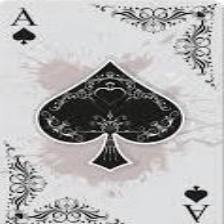

In [6]:
image, label = dataset[500]
print(label)
image

In [7]:
# GEt a dictionary associating target values with folder names
data_dir  = '/kaggle/input/cards-image-datasetclassification/train'
target_to_class = {v:k for k,v in ImageFolder(data_dir).class_to_idx.items()}

In [8]:
transform = transforms.Compose ([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [9]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [10]:
# iterate over dataset
for image, label in dataset :
    break

## Dataloaders 

- Batching our dataset.
- It's faster to train the model in batches instead of one at a time

In [11]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [12]:
for images, labels in dataloader :
    break

In [13]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [14]:
labels

tensor([ 7, 20, 30, 10, 30,  9, 17, 37, 31, 21, 17, 24, 36, 52, 44, 45,  2, 28,
        36, 41, 21, 16, 11, 14, 31,  4, 28, 45,  3, 37, 41, 40])

# Step 2. Pytorch Model

In [15]:
class SimpleCardClassifer (nn.Module) :
    def __init__(self, num_classes=53) :
        super(SimpleCardClassifer,self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self,x) :
        #connect these parts and return the output
        x=self.features(x)
        output = self.classifier(x)
        return output

In [16]:
model = SimpleCardClassifer(num_classes = 53)
print(str(model)[:500])

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [17]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

# Step 3. The training loop

In [18]:
# Loss Function 
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
criterion(example_out,labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


## Setup Datasets

In [20]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

train_folder = '../input/cards-image-datasetclassification/train/'
valid_folder = '../input/cards-image-datasetclassification/valid/'
test_folder = '../input/cards-image-datasetclassification/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

## Simple Training Loop

In [21]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs) :
    #training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop') :
        #move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(images)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item()*labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss=0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc = 'Validation loop') :
            #move inputs and labels to device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        val_loss = running_loss /len(valid_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch +1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss} ")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.559326606307175, Validation loss: 0.3676380724277136 


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5690389825001844, Validation loss: 0.27324406470892565 


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3348694164560011, Validation loss: 0.2113958273293837 


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2568630415082353, Validation loss: 0.1820935145863947 


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1791485858942379, Validation loss: 0.16383450661065443 


## Visualize Losses

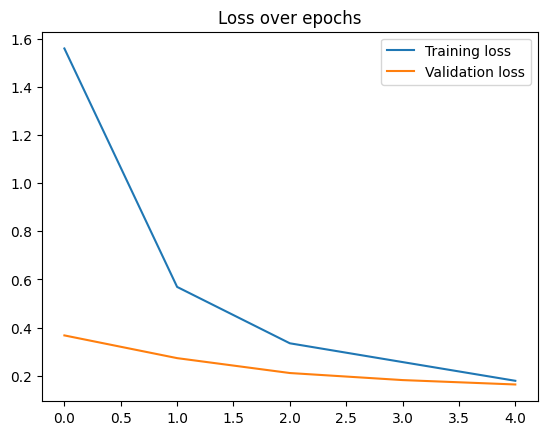

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Evaluating the Results

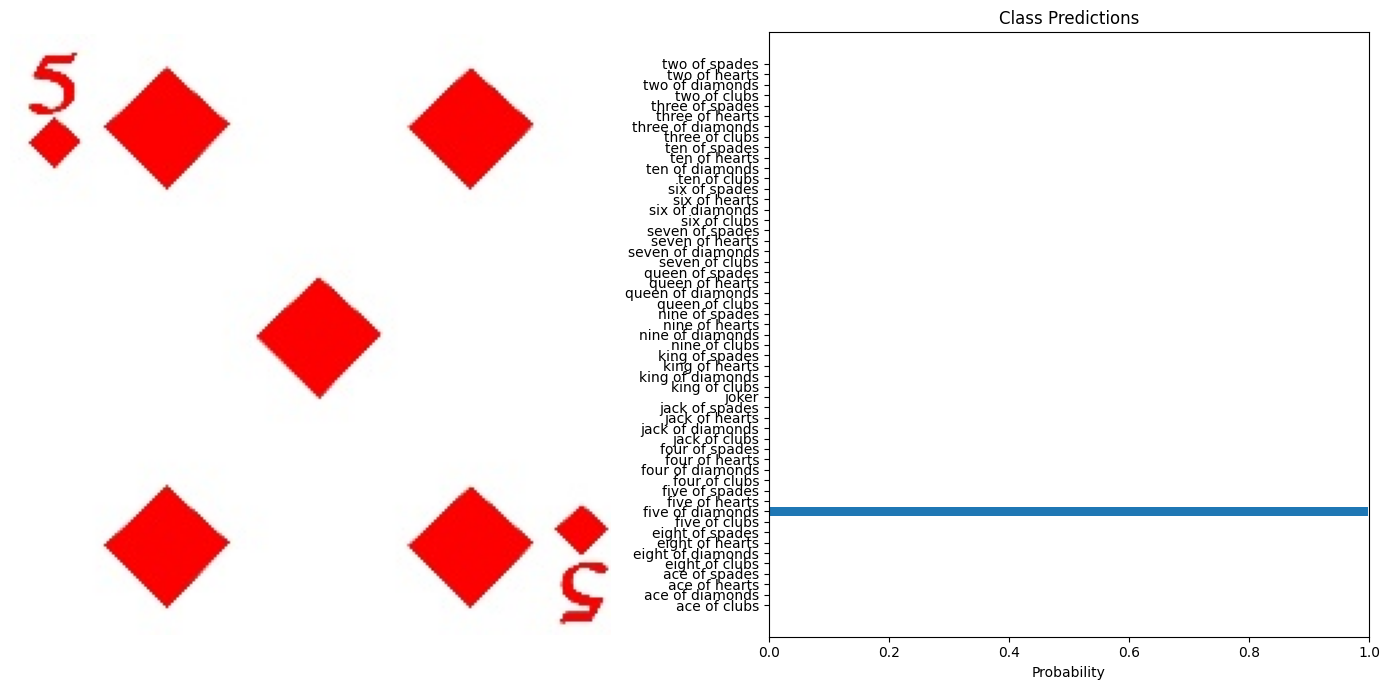

In [24]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

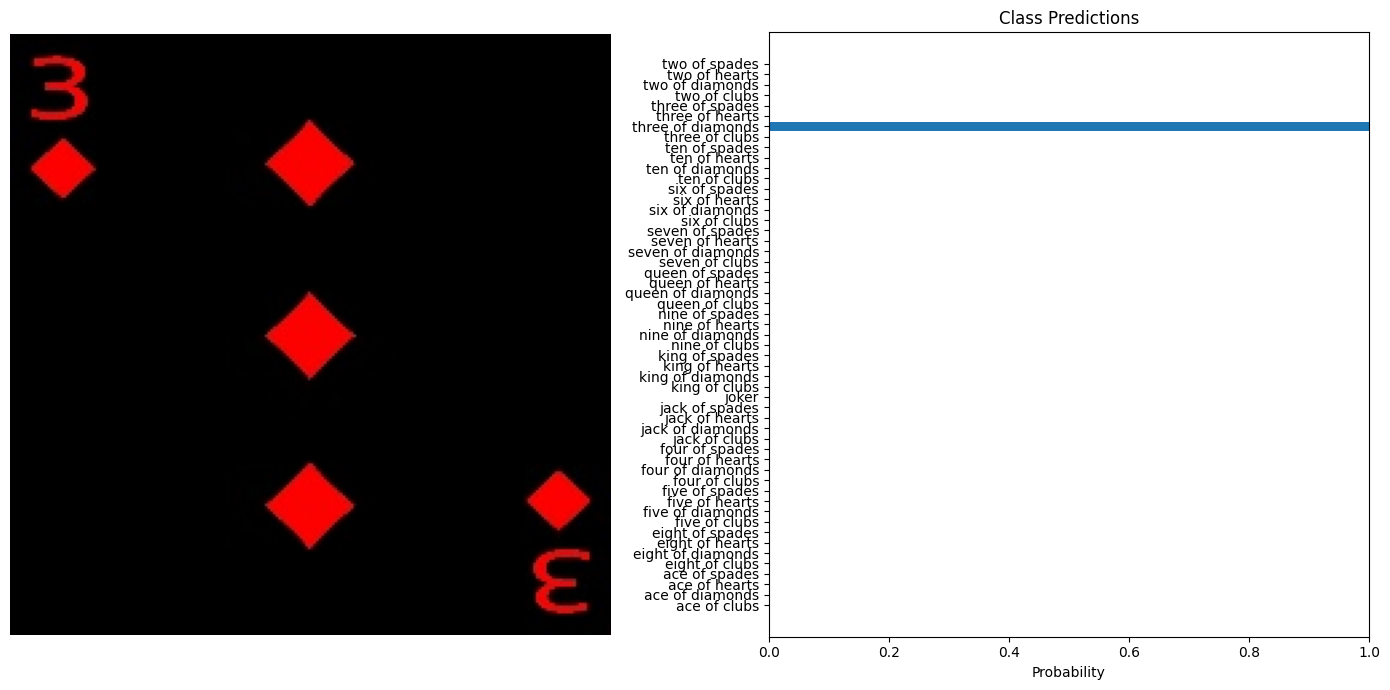

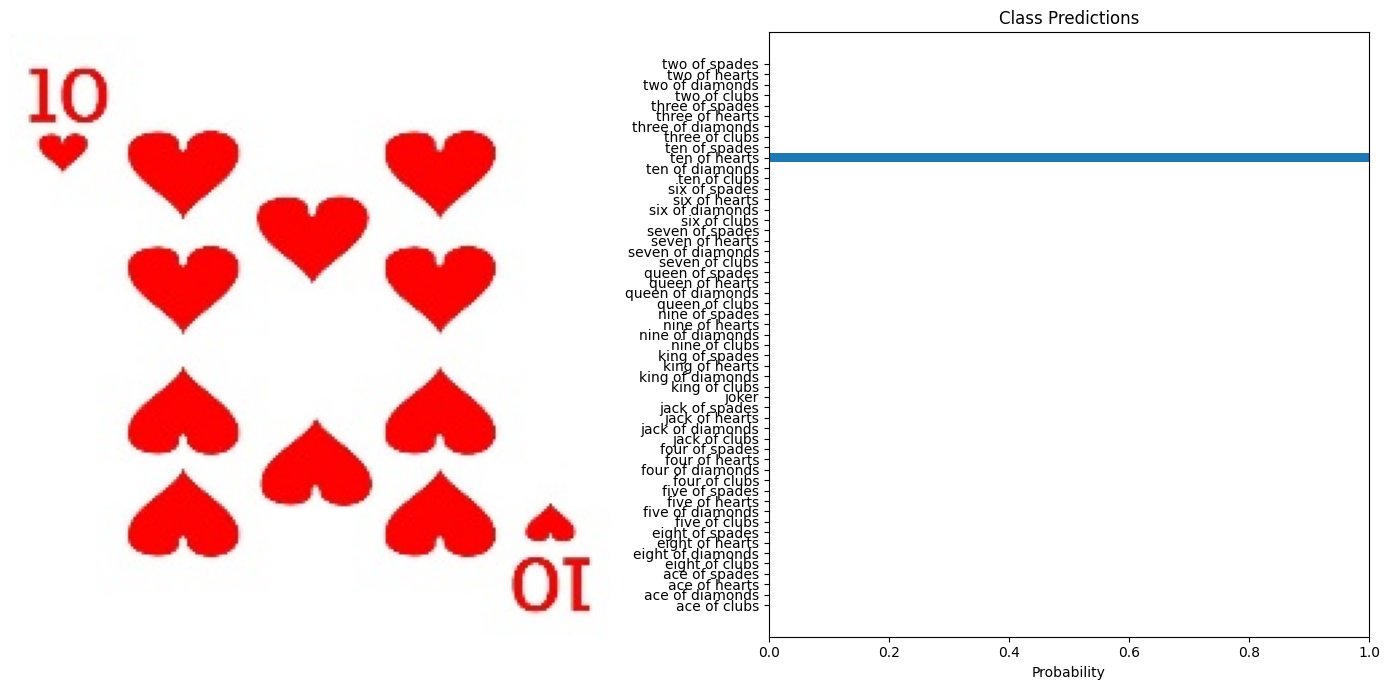

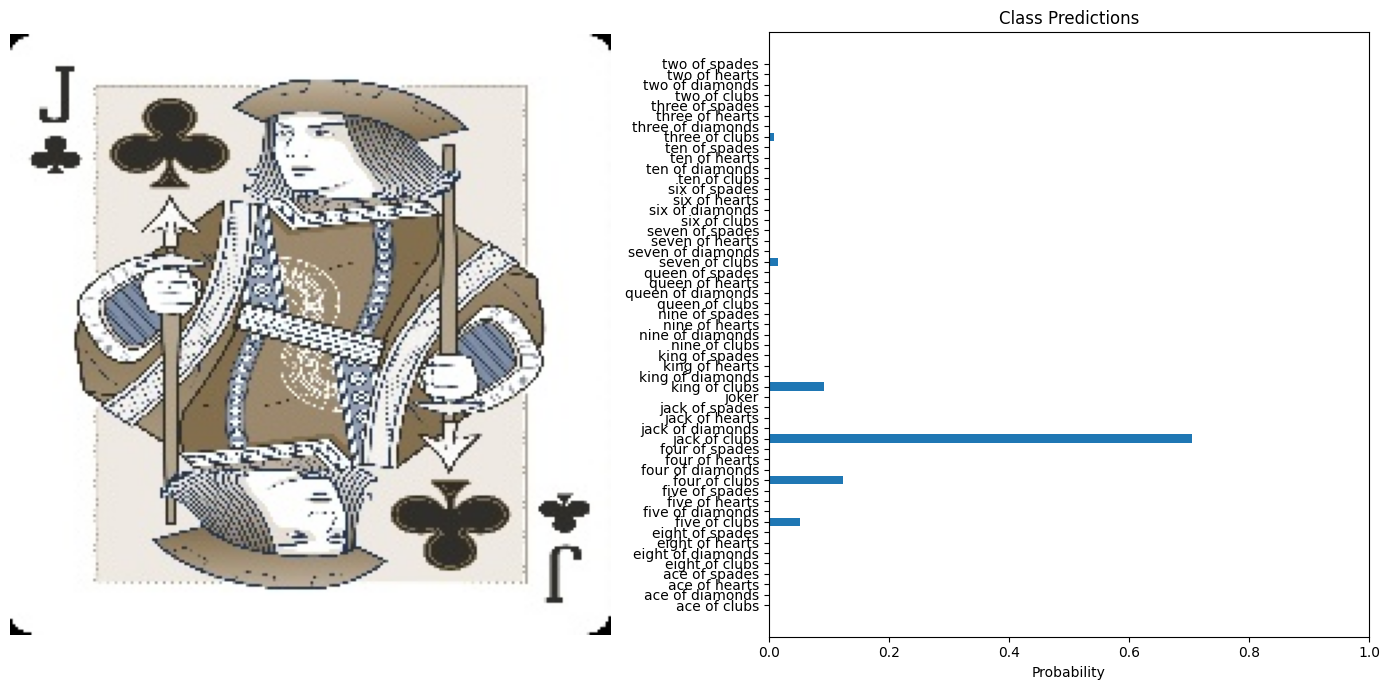

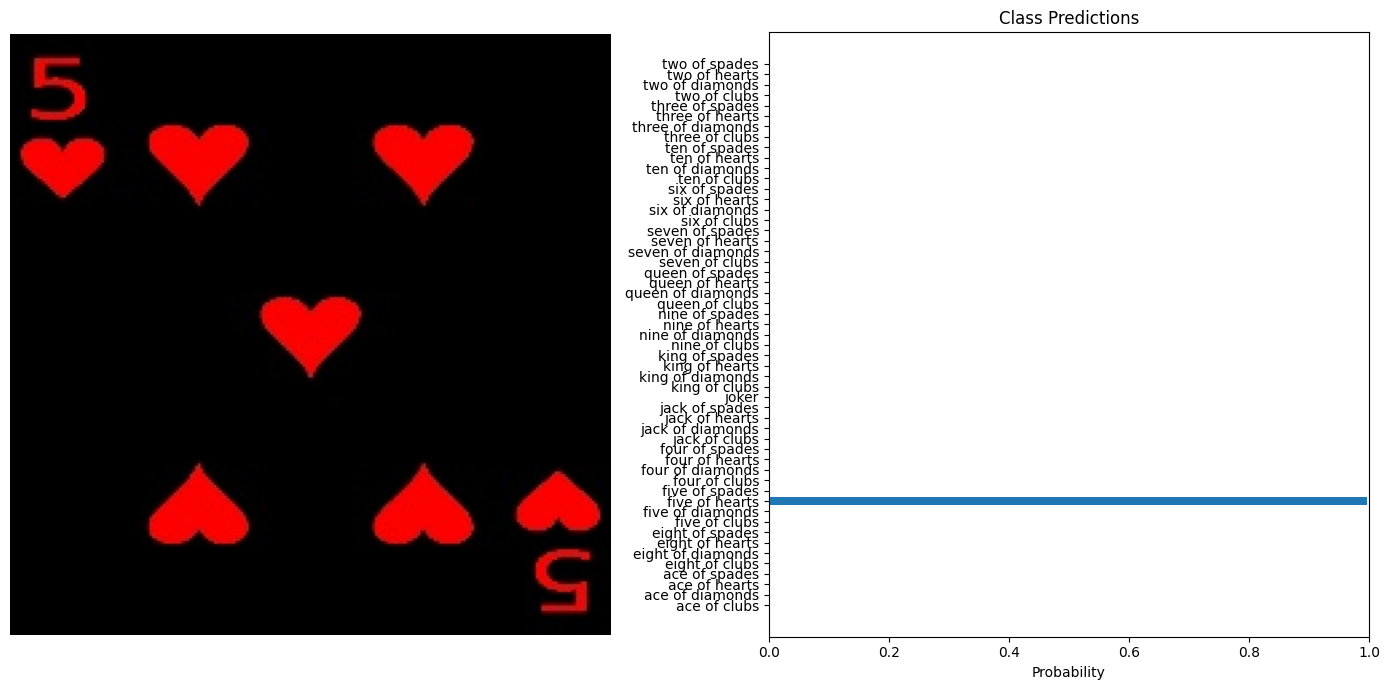

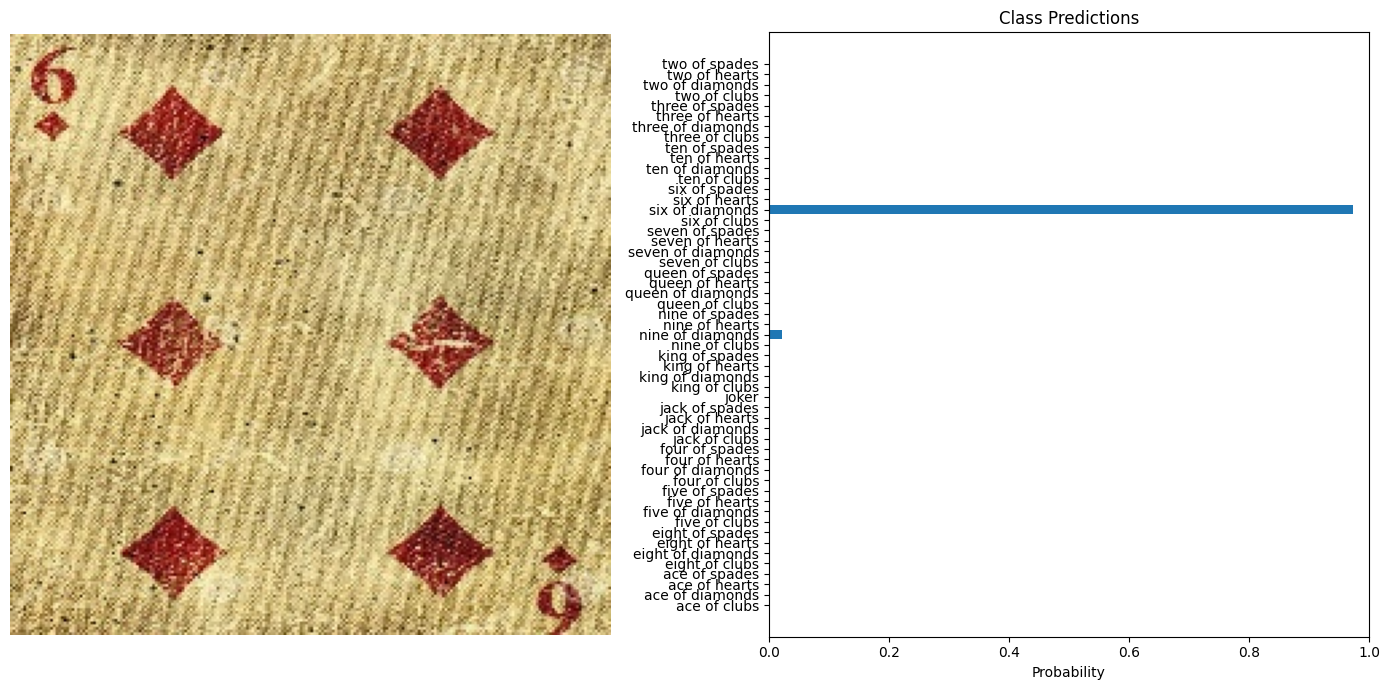

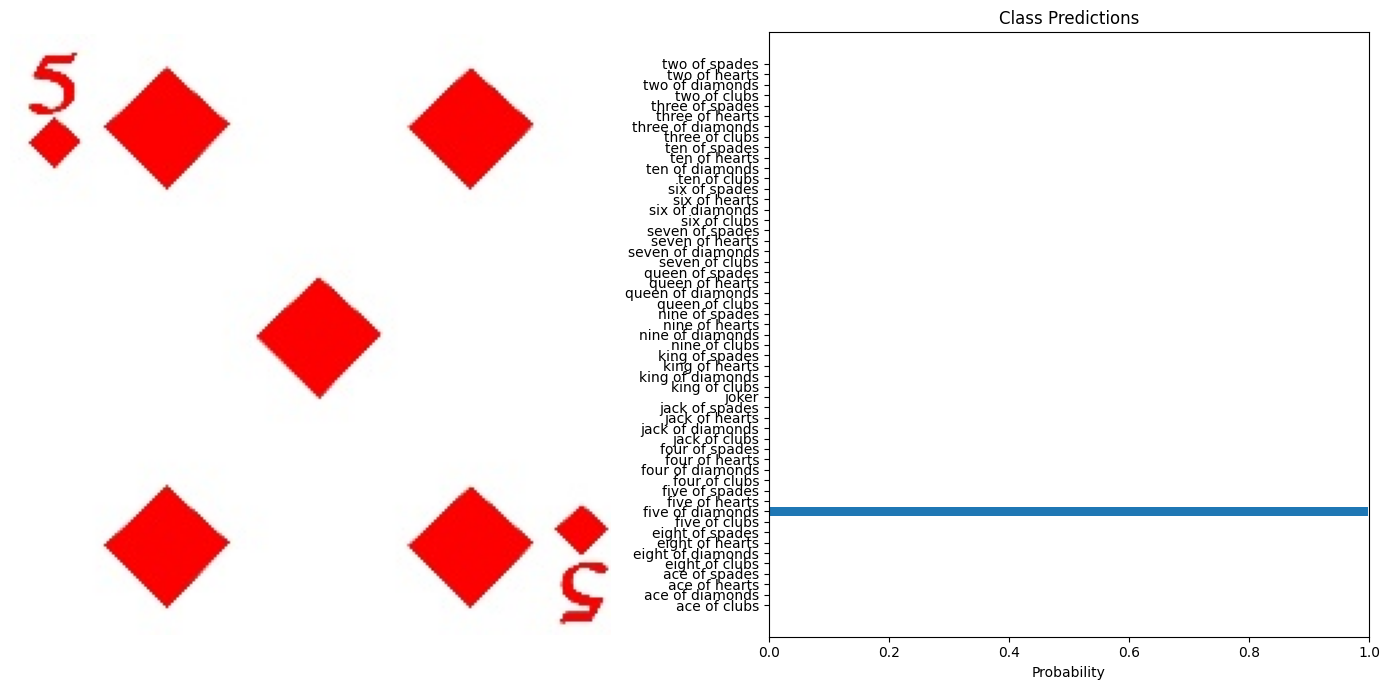

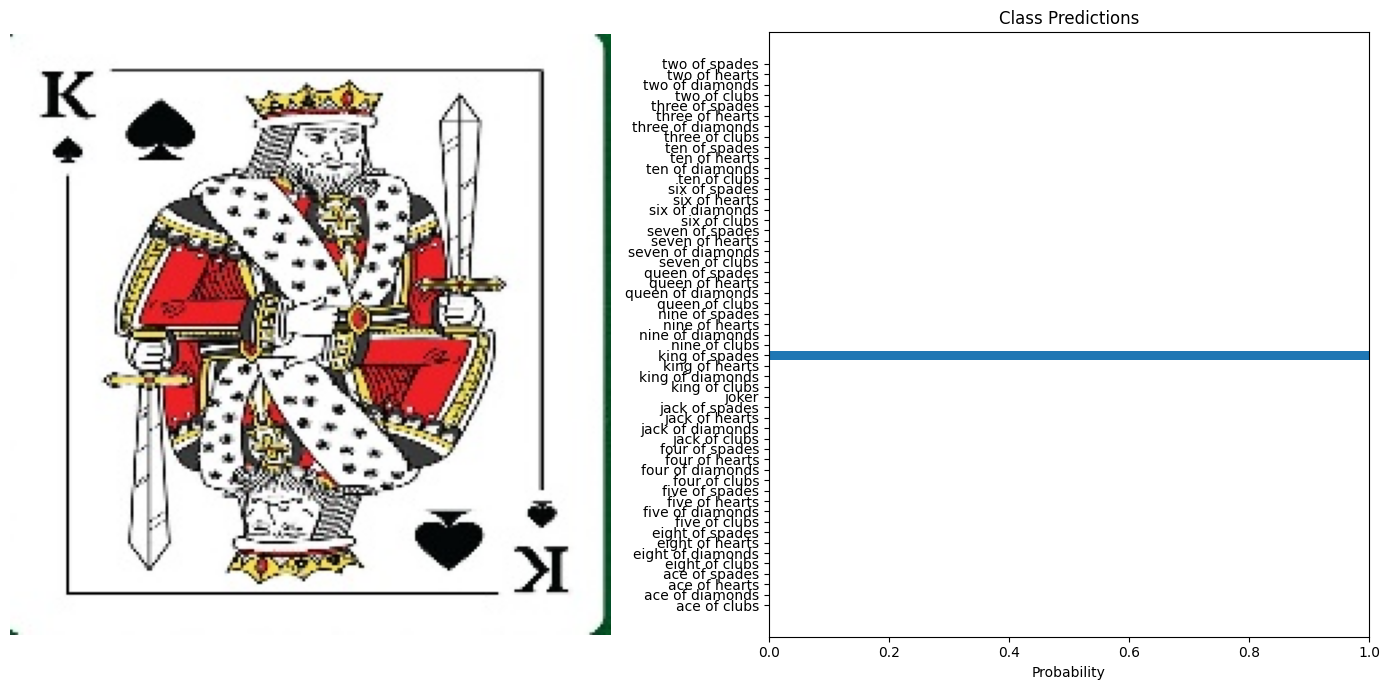

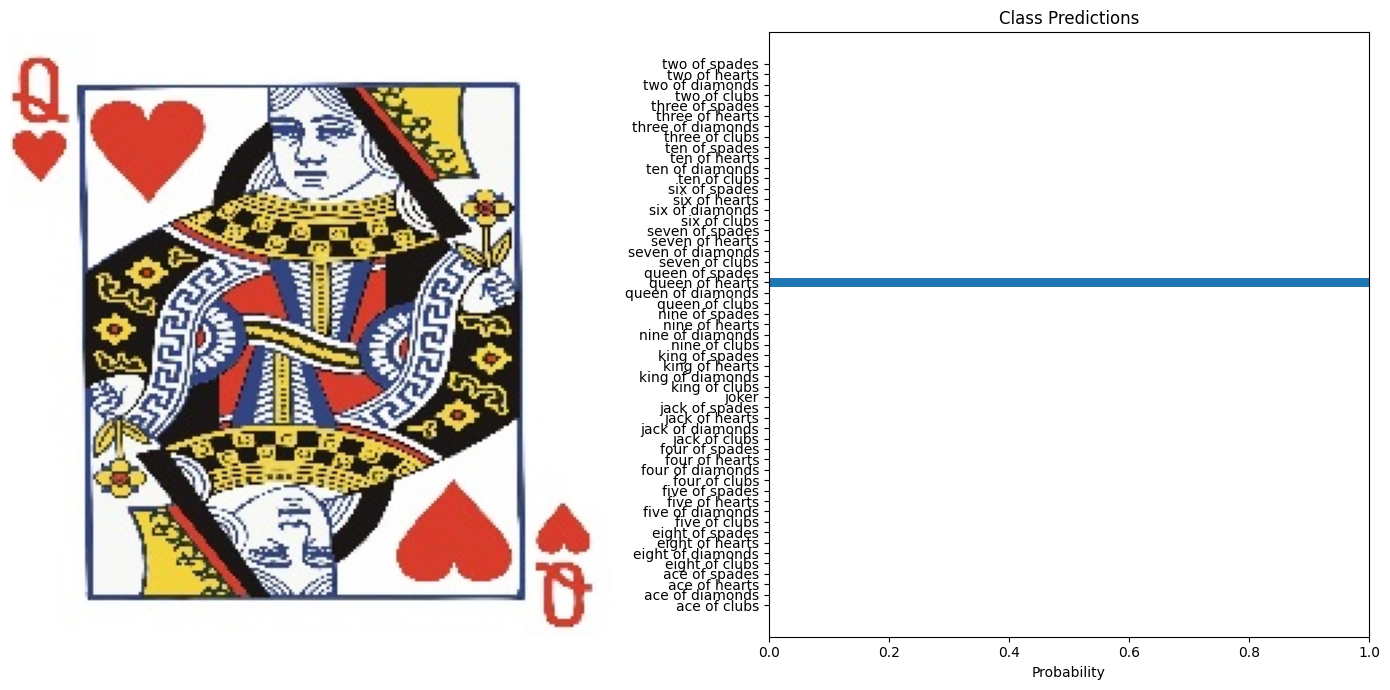

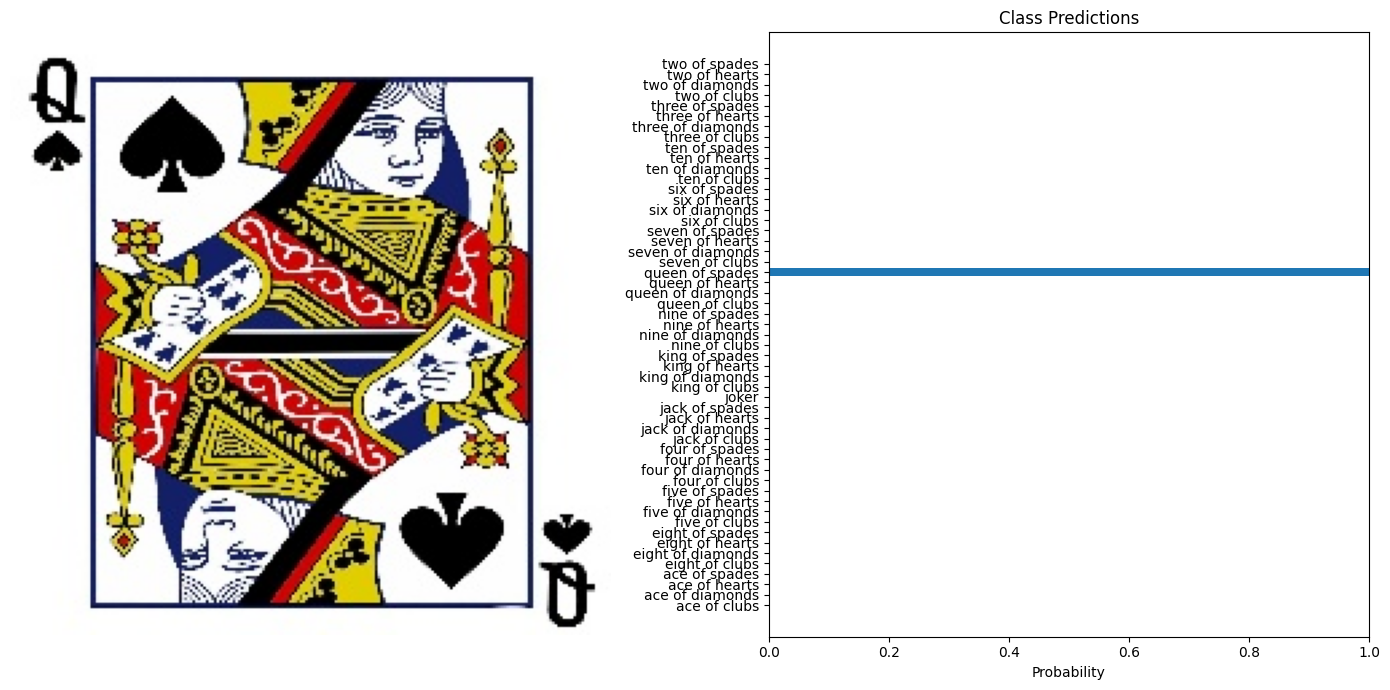

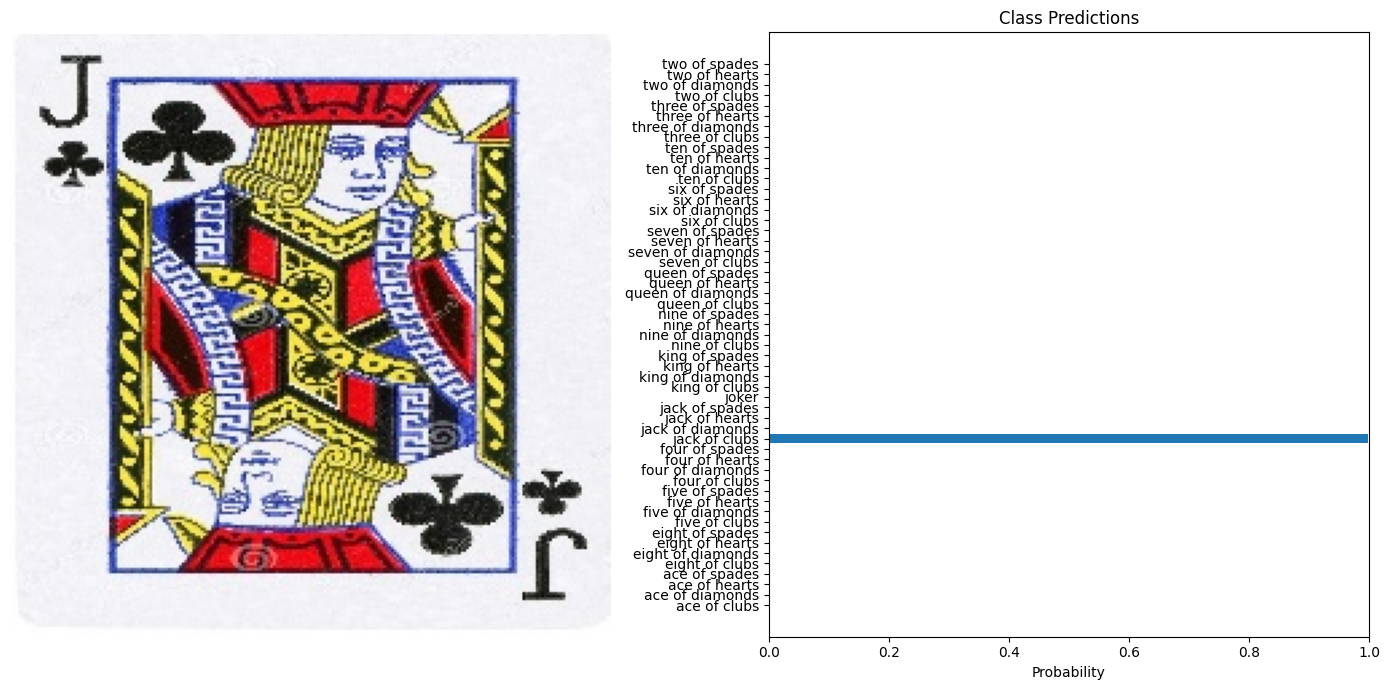

In [25]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

## Accuracy of the model

In [26]:
def compute_accuracy(model, test_loader, device):
    model.eval()  # Met le modèle en mode évaluation
    correct = 0
    total = 0

    with torch.no_grad():  # Désactive le calcul des gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Envoie les données sur GPU/CPU
            outputs = model(images)  # Prédictions du modèle
            
            _, predicted = torch.max(outputs, 1)  # Indice de la classe avec la plus grande probabilité
            correct += (predicted == labels).sum().item()  # Compare et compte les bonnes prédictions
            total += labels.size(0)  # Nombre total d’exemples

    accuracy = 100 * correct / total  # Calcul du pourcentage d'exactitude
    return accuracy

# Exemple d'utilisation :
# Supposons que `model` soit déjà entraîné et `test_loader` contienne les données de test.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU si dispo
model.to(device)  # Envoie le modèle sur GPU/CPU

accuracy = compute_accuracy(model, test_loader, device)
print(f"Exactitude du modèle sur le test set : {accuracy:.2f}%")

Exactitude du modèle sur le test set : 95.47%
